# STAT 301 Final Project: Group 22

### Group members: Siluni Jayarathne, Bhumika Kalra, Jeff Lu, Sofiia Prylypka

## Table of contents:
* [Introduction](#Introduction)
* [Method and Results](#Method-and-Results)
* [Discussion](#Discussion)
* [References](#References)

## Introduction
- Thanks to the rapid digitalization of the world, online shopping has begun reaching a wider audience than ever. As a result, there has been a large push for retail companies to curate personalized shopping experiences for customers. However, the factors that influence whether a customer ultimately makes a purchase are complex and not yet fully understood (Zhou et al., 2017), making it unclear which aspects of a website should be personalized to maximize revenue.
- Because of this, we would like to determine the association between a site visitor's purchasing decision (response), and predictors related to the site visitor's browsing behaviour (e.g. time spent on various types of pages, web page bounce rate) and time of site visit (e.g. whether the user visited on a special day or weekend). Our primary goal is inference, since we are trying to understand which predictors are relevant to purchasing decisions, rather than trying to predict a new visitor's purchasing decision.

## Method and Results

### Data

In [4]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(broom)
library(car)
library(MASS)
library(tidymodels)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ rsample      1.2.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata

In [5]:
# Do not change
set.seed(1234)

# Download and load dataset from the Web
zipped <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip", zipped)
unzipped <- unz(zipped, "online_shoppers_intention.csv")
shopping <- read.csv(unzipped) |> 
    filter(Region != 1) # As required for our group's data

# Split into selection and inference sets to avoid the post-inference problem
shopping_split <- initial_split(shopping, prop = 0.5, strata = Revenue)
shopping_selection <- training(shopping_split)
# Do not touch this set until the final step
shopping_inference <- testing(shopping_split)

head(shopping_selection, 3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<lgl>,<lgl>
1,0,0,0,0,1,0,0.2,0.20000000,0,0.4,Feb,2,4,3,3,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,3,395,0.0,0.06666667,0,0.0,Feb,1,1,3,3,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,1,0,0.2,0.20000000,0,0.0,Feb,1,1,4,3,Returning_Visitor,FALSE,FALSE


##### Dataset summary
- For this project, our group will be working with the [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset).
- This dataset was collected from an observational study and includes data about browser sessions of users visiting an online shopping website.
- The dataset contains 18 variables (described below) for 12,330 observations, with no missing values; however, we will only use observations where the Region is not 1, as specified in our group's instructions.
<table><thead>
  <tr>
    <th>Variable Name</th>
    <th>Type</th>
    <th>Description</th>
    <th>Data collection method</th>
  </tr></thead>
<tbody>
  <tr>
    <td>Administrative</td>
    <td>Integer</td>
    <td>Number of administrative pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Administrative_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on administrative pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Informational</td>
    <td>Integer</td>
    <td>Number of informational pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>Informational_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on informational pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>ProductRelated</td>
    <td>Integer</td>
    <td>Number of product-related pages visited</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>ProductRelated_Duration</td>
    <td>Continuous</td>
    <td>Total time spent on product-related pages (s)</td>
    <td>Derived from URL information</td>
  </tr>
  <tr>
    <td>BounceRates</td>
    <td>Continuous</td>
    <td>Average bounce rate (leaving a page without analytics server requests) of pages visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>ExitRates</td>
    <td>Continuous</td>
    <td>Average exit rate of pages visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>PageValues</td>
    <td>Continuous</td>
    <td>Average value for a web page visited</td>
    <td>Google Analytics</td>
  </tr>
  <tr>
    <td>SpecialDay</td>
    <td>Continuous</td>
    <td>Value between 0 and 1 indicating closeness of site visit to special day</td>
    <td>Calculated based on dynamics of e-commerce</td>
  </tr>
  <tr>
    <td>Month</td>
    <td>Categorical</td>
    <td>Month of site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>OperatingSystems</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Operating system used during site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Browser</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Browser used during site visit</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Region</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Geographic region of session</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>TrafficType</td>
    <td>Categorical (encoded as Integer)</td>
    <td>Type of traffic that brought visitor to site</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>VisitorType</td>
    <td>Categorical</td>
    <td>"Returning Visitor," "New Visitor," or "Other"</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Weekend</td>
    <td>Binary</td>
    <td>Whether the site visit was on a weekend</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Revenue</td>
    <td>Binary</td>
    <td>Whether the session ended in a transaction</td>
    <td>NA</td>
  </tr>
</tbody></table>

### Exploratory Data Analysis

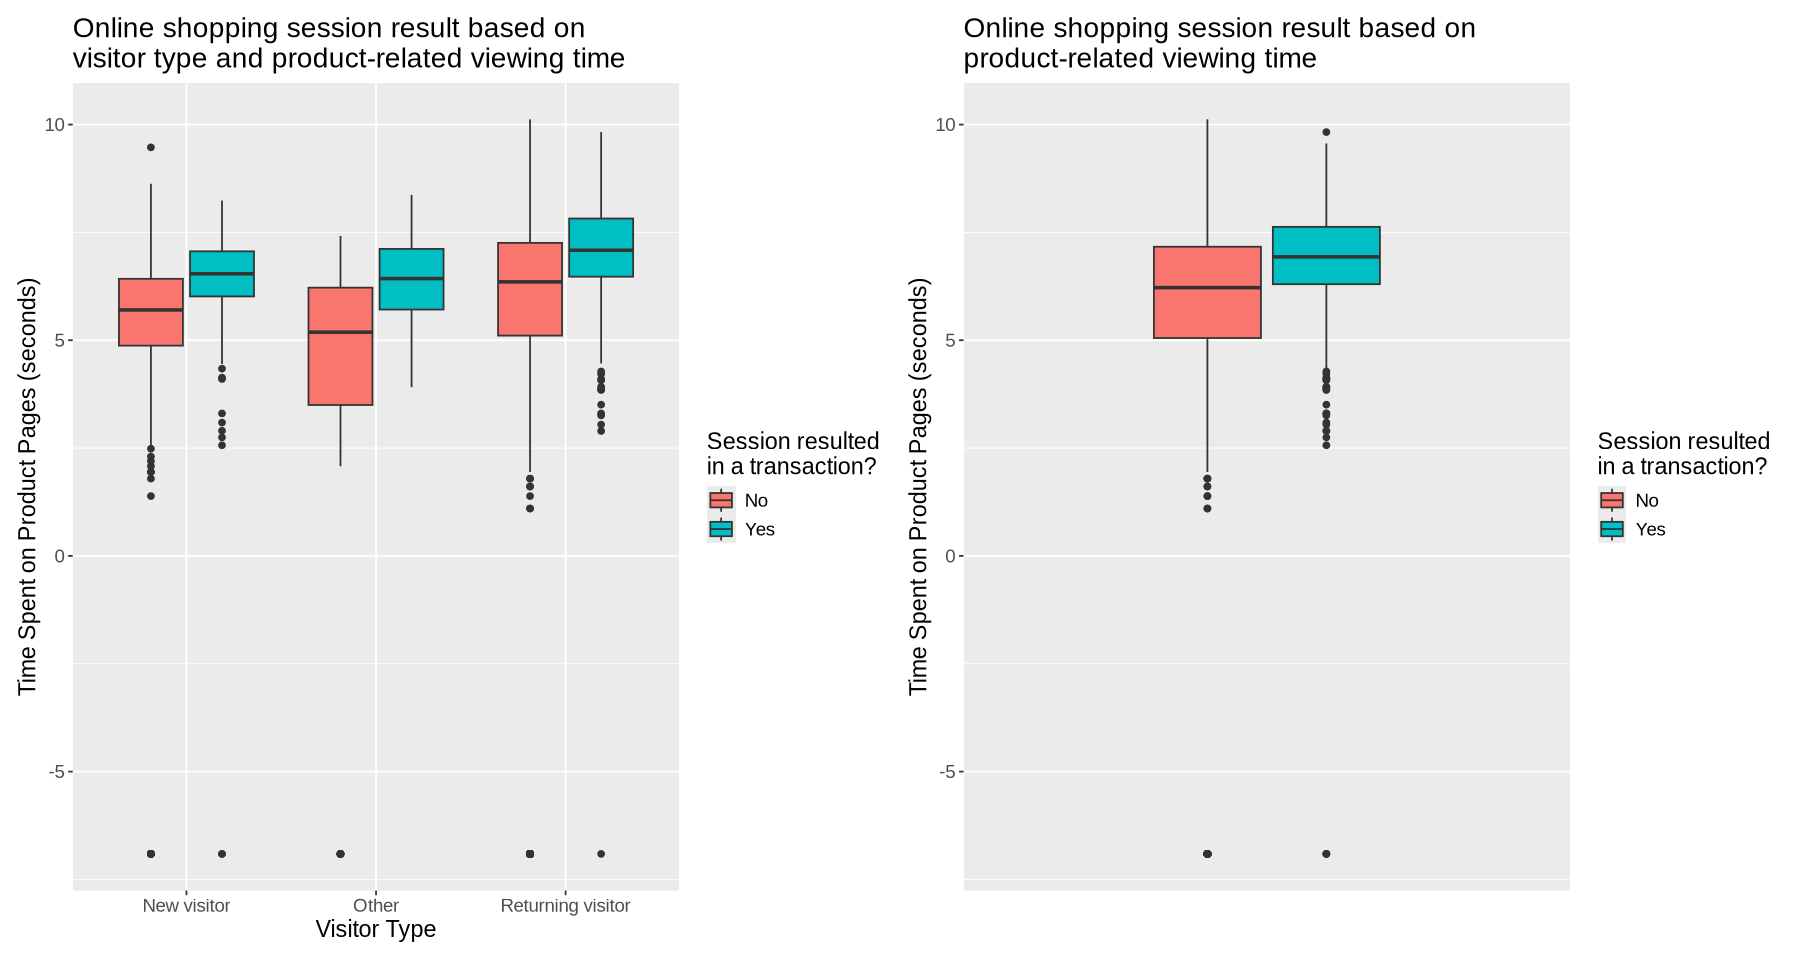

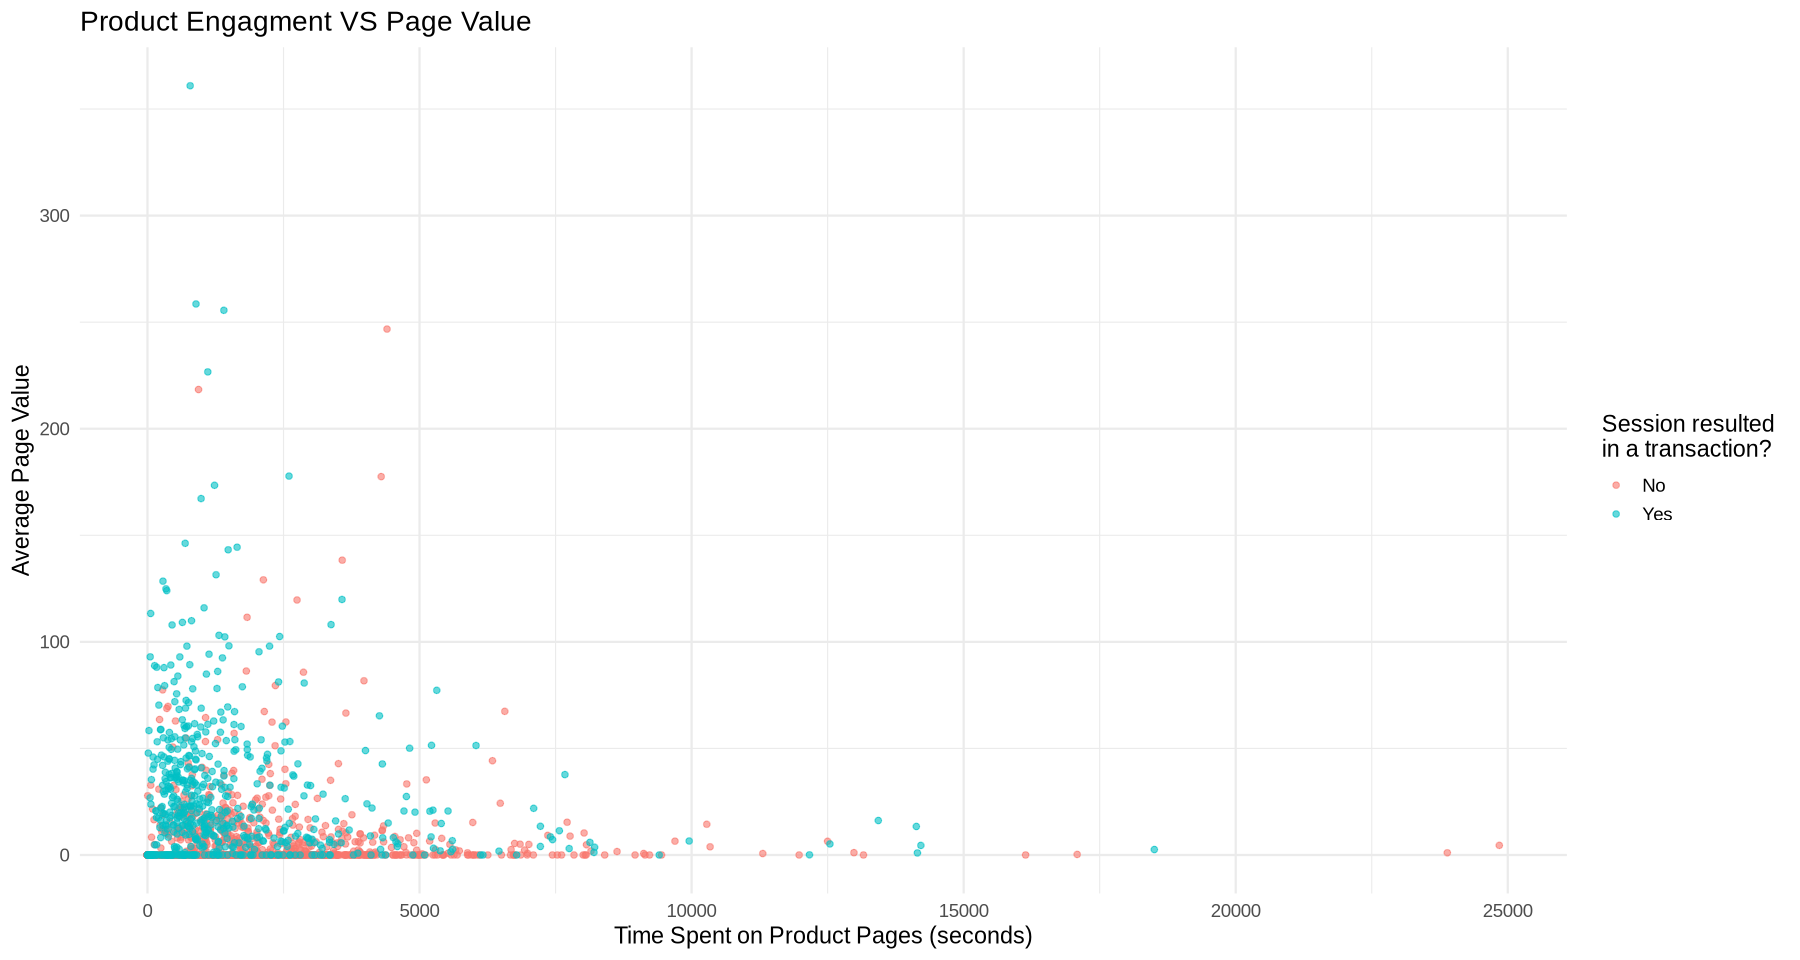

In [6]:
options(repr.plot.height = 8, repr.plot.width = 15)

# Visualization 1
vis_by_visitor_type <- ggplot(shopping_selection) +
    # Use log scale for y due to large variance; add small constant to smooth zero values
    geom_boxplot(aes(y = log(ProductRelated_Duration + 0.001), x = VisitorType, fill = Revenue)) +
    labs(y = "Time Spent on Product Pages (seconds)",
         fill = "Session resulted\nin a transaction?", x = "Visitor Type") +
    scale_fill_discrete(labels = c("No", "Yes")) +
    scale_x_discrete(labels = c("New visitor", "Other", "Returning visitor")) +
    theme(text = element_text(size = 14)) +
    ggtitle("Online shopping session result based on\nvisitor type and product-related viewing time")

vis_aggregated <- ggplot(shopping_selection) +
    # Use log scale for y due to large variance; add small constant to smooth zero values
    geom_boxplot(aes(y = log(ProductRelated_Duration + 0.001), fill = Revenue)) +
    labs(y = "Time Spent on Product Pages (seconds)",
         fill = "Session resulted\nin a transaction?") +
    scale_fill_discrete(labels = c("No", "Yes")) +
    scale_x_discrete(labels = c()) +
    theme(text = element_text(size = 14)) +
    ggtitle("Online shopping session result based on\nproduct-related viewing time")
vis_by_visitor_type + vis_aggregated

# Visualization 2
online_shopping_plot <-
    ggplot(shopping_selection, aes(x = ProductRelated_Duration, y = PageValues, color = Revenue))+
    geom_point(alpha = 0.6) +
    labs(
        x = "Time Spent on Product Pages (seconds)",
        y = "Average Page Value",
        title = "Product Engagment VS Page Value",
        color = "Session resulted\nin a transaction?") +
    theme_minimal(base_size = 14) +
    scale_color_discrete(labels = c("No", "Yes"))

online_shopping_plot

### Methods: Plan

- We will first use `stepAIC()` to perform forward variable selection solely on `shopping_selection`. Since our dataset has many categorical variables, `stepAIC` will allow us to select all dummy variables associated with each categorical variable. This will lead to greater interpretability, which is important for inference.
- Using the variables selected, we will then fit an additive logistic regression model on `shopping_selection` using `Revenue` as the response on `shopping_selection` and use GVIF to check for multicollinearity. If the GVIF for any covariate is greater than 5, we will remove it from the variable set when doing inference.
- Using a logistic regression model is appropriate because the response variable `Revenue` is binary, so it will ensure that the fitted values are bounded between 0 and 1 as they should be. Also, using logistic regression will make the interpretation much more intuitive (e.g. we can say some variable is associated with some increase in the *odds* of a session resulting in a purchase), which is important for inference.
- Finally, we will fit an additive logistic regression model on `shopping_inference` using `Revenue` as the response and interpret the results.

### Code and Results

In [14]:

#null model
shopping_null <- glm(Revenue ~ 1, family = binomial, data = shopping_selection)
shopping_null_results <- shopping_null %>% tidy()

#full model with all covariates
shopping_full <- glm(Revenue ~ ., family = binomial, data = shopping_selection)
shopping_full_results <- shopping_full %>% tidy()

#forward selection on null model
AIC_forward <- stepAIC(shopping_null, direction = "forward", k = log(nrow(shopping_selection)), 
                       scope = list(lower = shopping_null, upper = shopping_full))

#summary of the forward selection
summary(AIC_forward)

#The selected variables from forward selection were PageValues+ExitRates+Month+ProductRelated_Duration


Start:  AIC=3205.43
Revenue ~ 1

                          Df Deviance    AIC
+ PageValues               1   2391.4 2407.8
+ ExitRates                1   2872.0 2888.5
+ BounceRates              1   3009.9 3026.4
+ ProductRelated_Duration  1   3132.5 3149.0
+ ProductRelated           1   3134.6 3151.1
+ Administrative           1   3152.6 3169.0
+ Month                    9   3093.5 3175.8
+ VisitorType              2   3159.8 3184.5
+ SpecialDay               1   3172.2 3188.7
+ Administrative_Duration  1   3177.4 3193.9
+ Informational            1   3179.3 3195.8
<none>                         3197.2 3205.4
+ Informational_Duration   1   3190.2 3206.7
+ Browser                  1   3193.1 3209.5
+ Weekend                  1   3193.7 3210.2
+ OperatingSystems         1   3197.1 3213.5
+ Region                   1   3197.1 3213.6
+ TrafficType              1   3197.2 3213.6

Step:  AIC=2407.85
Revenue ~ PageValues

                          Df Deviance    AIC
+ ExitRates              


Call:
glm(formula = Revenue ~ PageValues + ExitRates + Month + ProductRelated_Duration, 
    family = binomial, data = shopping_selection)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.650e+00  2.763e-01  -5.972 2.34e-09 ***
PageValues               7.541e-02  4.120e-03  18.302  < 2e-16 ***
ExitRates               -2.440e+01  3.284e+00  -7.429 1.09e-13 ***
MonthDec                -5.186e-01  3.103e-01  -1.671  0.09466 .  
MonthFeb                -1.731e+00  1.099e+00  -1.575  0.11525    
MonthJul                 2.047e-01  3.729e-01   0.549  0.58309    
MonthJune               -3.453e-01  5.298e-01  -0.652  0.51461    
MonthMar                -7.812e-01  3.185e-01  -2.453  0.01418 *  
MonthMay                -5.093e-01  2.874e-01  -1.772  0.07642 .  
MonthNov                 5.143e-01  2.789e-01   1.844  0.06515 .  
MonthOct                -2.121e-01  3.640e-01  -0.583  0.56016    
MonthSep                -2.858e-01  3.655

In [17]:
#fit an additive model on selected variables
shopping_selected <- glm(Revenue ~ PageValues+ExitRates+Month+ProductRelated_Duration,
                         family = binomial, data = shopping_selection)

#check for multicollinearity in the selected model 
shopping_selected_vif <- shopping_selected %>% vif()
shopping_selected_vif

#since none of the coviates have gvif > 5 we will not remove any covariates.


,GVIF,Df,GVIF^(1/(2*Df))
PageValues,1.050848,1,1.025109
ExitRates,1.040767,1,1.020180
Month,1.061442,9,1.003318
ProductRelated_Duration,1.038448,1,1.019043


## Discussion

## References
Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention Dataset [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q

Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2018). Real-time prediction of online shoppers’ purchasing intention using Multilayer Perceptron and LSTM recurrent neural networks. *Neural Computing and Applications*, 31(10), 6893–6908. https://doi.org/10.1007/s00521-018-3523-0 

Zhou, L., Dai, L., & Zhang, D. (2007). Online shopping acceptance model — A critical survey of consumer factors in online shopping. *Journal of Electronic Commerce Research*, 8(1).

Link to download dataset: https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip